## Install Dependencies

In [ ]:
!pip install -q transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.6 MB/s eta 0:00:00


## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import re
import torch


## Load and Prepare the Dataset

In [ ]:
df1 = pd.read_csv("/content/kinyarwanda_hard_texts.csv")
df2 = pd.read_csv("/content/realistic_kinyarwanda_hate_sarcasm_normal.csv")
df = pd.concat([df1, df2], ignore_index=True)
df.head()

# Clean labels
df["label"] = df["label"].str.strip().str.lower()
df["label"] = df["label"].replace({"sarcasm/joke": "sarcasm"})
df.head()


,text,label
0,"Noneho Ndumva Ubwo Hahaha, ntacyo, murakoze cy...",sarcasm
1,Hmmm Ngo Ngo Ngo Abanzi b’igihugu bakwiye guku...,hate
2,Noneho Murakoze Ngo Ngo Ndumva Iyo myitwarire ...,hate
3,"Murakoze Ndumva Hahaha, ntacyo, murakoze cyane...",sarcasm
4,"Hmmm Ubwo Hahaha, ntacyo, murakoze cyane pe, n...",sarcasm


In [ ]:
df.shape

(18073, 2)

### label distribution

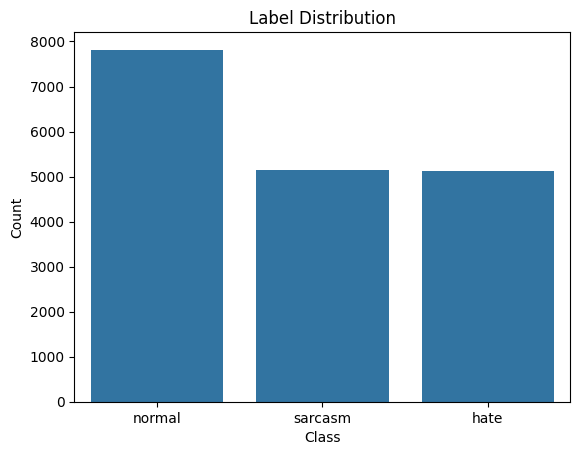

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x="label", order=df["label"].value_counts().index)
plt.title("Label Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

### label encoding

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
df["label_id"] = label_encoder.fit_transform(df["label"])

num_labels = len(label_encoder.classes_)
label_encoder.classes_

array(['hate', 'normal', 'sarcasm'], dtype=object)

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)
    return text.strip()

df["text"] = df["text"].apply(clean_text)
df.head()

,text,label,label_id
0,noneho ndumva ubwo hahaha ntacyo murakoze cyan...,sarcasm,2
1,hmm ngo ngo ngo abanzi bigihugu bakwiye gukuri...,hate,0
2,noneho murakoze ngo ngo ndumva iyo myitwarire ...,hate,0
3,murakoze ndumva hahaha ntacyo murakoze cyane p...,sarcasm,2
4,hmm ubwo hahaha ntacyo murakoze cyane pe ndabi...,sarcasm,2


## Train-Test Split + HuggingFace Dataset Conversion

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, stratify=df["label_id"], test_size=0.2, random_state=42)

train_ds = Dataset.from_pandas(train_df[["text", "label_id"]])
test_ds = Dataset.from_pandas(test_df[["text", "label_id"]])


### word cloud visuals

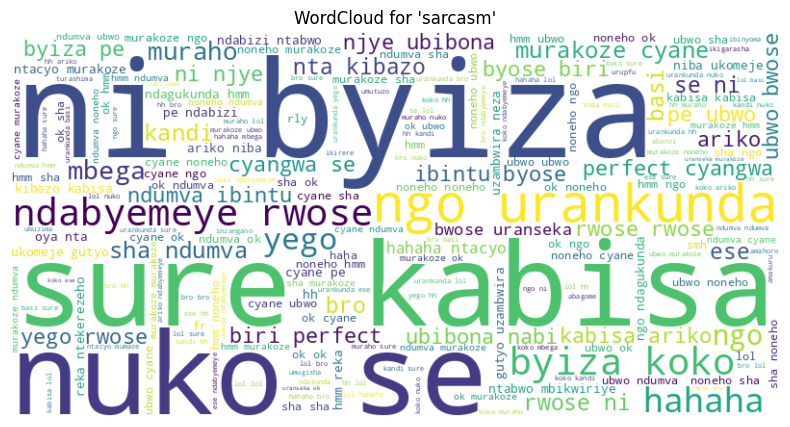

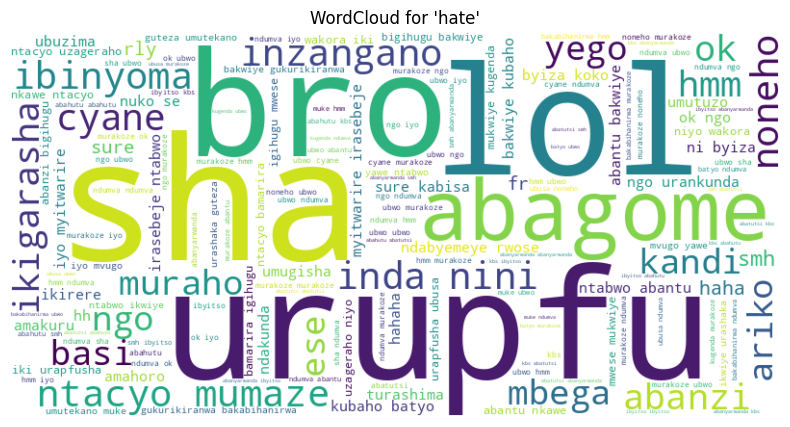

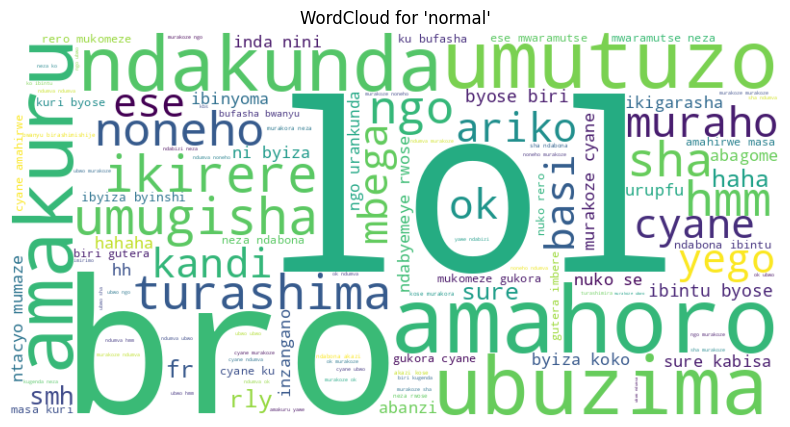

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for label in df["label"].unique():
    text = " ".join(df[df["label"] == label]["text"])
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"WordCloud for '{label}'")
    plt.axis("off")
    plt.show()


## Load Tokenizer & Tokenize Dataset

In [ ]:
model_name = "Davlan/afro-xlmr-mini"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_batch(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

train_ds = train_ds.map(tokenize_batch, batched=True)
test_ds = test_ds.map(tokenize_batch, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Map:   0%|          | 0/14458 [00:00<?, ? examples/s]

Map:   0%|          | 0/3615 [00:00<?, ? examples/s]

## Load Model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

config.json:   0%|          | 0.00/721 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/472M [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-mini and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define Metrics

In [ ]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1_macro": f1.compute(predictions=predictions, references=labels, average="macro")["f1"]
    }


## Set Training Arguments

In [ ]:
training_args = TrainingArguments(
    output_dir="afro-xlmr-mini-output",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    save_total_limit=2,
    fp16=torch.cuda.is_available()
)


In [ ]:
# Rename label column to what Trainer expects
train_ds = train_ds.rename_column("label_id", "labels")
test_ds = test_ds.rename_column("label_id", "labels")


## Create Trainer and Train

In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


/tmp/ipython-input-15-539005518.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: p-umutoniwa (p-umutoniwa-alu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.524800,0.071129,0.987275,0.986691
2,0.064800,0.048491,0.989765,0.989283
3,0.040600,0.035844,0.990595,0.990285


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.524800,0.071129,0.987275,0.986691
2,0.064800,0.048491,0.989765,0.989283
3,0.040600,0.035844,0.990595,0.990285
4,0.030400,0.036033,0.990595,0.990278


TrainOutput(global_step=3616, training_loss=0.11724119956514477, metrics={'train_runtime': 531.2098, 'train_samples_per_second': 108.868, 'train_steps_per_second': 6.807, 'total_flos': 952405031725056.0, 'train_loss': 0.11724119956514477, 'epoch': 4.0})

## Evaluate Model

In [16]:
metrics = trainer.evaluate()
metrics

{'eval_loss': 0.035844236612319946,
 'eval_accuracy': 0.9905947441217151,
 'eval_f1_macro': 0.9902849619634021,
 'eval_runtime': 2.7427,
 'eval_samples_per_second': 1318.066,
 'eval_steps_per_second': 41.201,
 'epoch': 4.0}

### Confusion Matrix

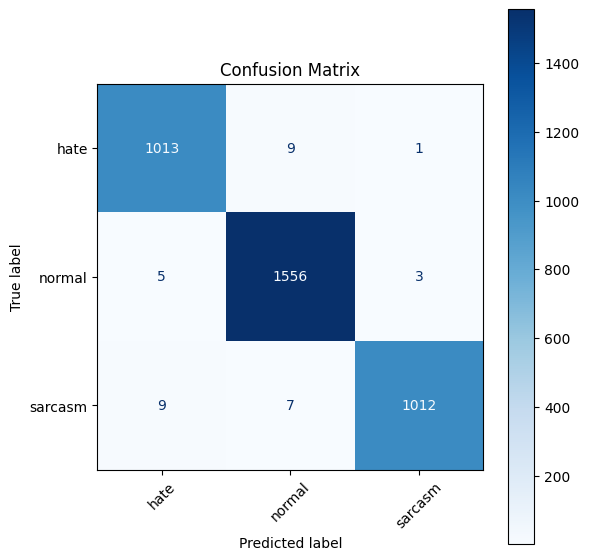

In [17]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# # Get true labels and predictions
# true_labels = test_df["label_id"].values
# test_texts = test_df["text"].tolist()

# pred_labels = []
# for text in test_texts:
#     inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
#     # Move input tensors to the same device as the model
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     model.to(device)  # Ensure model is on the correct device

#     outputs = model(**inputs)
#     pred = torch.argmax(outputs.logits, dim=1).item()
#     pred_labels.append(pred)

# # Plot confusion matrix
# cm = confusion_matrix(true_labels, pred_labels)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
# disp.plot(cmap="Blues", xticks_rotation=45)
# plt.title("Confusion Matrix")
# plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Get true labels and texts
true_labels = test_df["label_id"].values
test_texts = test_df["text"].tolist()

# Run model predictions
pred_labels = []
model.eval()  # Set model to eval mode

with torch.no_grad():
    for text in test_texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()
        pred_labels.append(pred)

# Generate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="Blues", xticks_rotation=45, ax=ax)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

### Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, pred_labels, target_names=label_encoder.classes_))


## Inference Examples

In [ ]:
def predict_label(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    # Move input tensors to the same device as the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.to(device)  # Ensure model is on the correct device

    outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits, dim=1).item()
    return label_encoder.inverse_transform([predicted_class])[0]

# Test examples
examples = [
    "Umwana na se",  # should be normal
    "Abatutsi baracyariho",  # hate
    "Uwanga umwana ntakabone ijuru",  # normal
    "U Rwanda n igihugu kiza",  # normal
    "Inyenzi ninde wakubeshye ko zashize mu Rwanda",  # ambiguous
]

for ex in examples:
    print(f"{ex} → {predict_label(ex)}")

## more examples (adding emojis)

In [20]:
examples = [
    "Sha murabeshya cyane 😂 ngo mwatsinze? Hmmm",
    "Abahutu ntacyo bamaze, rwose.",
    "Muraho neza, ndabashimiye ku bufasha bwanyu 🙏",
    "Ese wowe urumva nkwiye kwemera ibyo? Sha uransetsa kabisa",
    "Iyo myitwarire y’abatutsi ntitwakwihanganira pe!",
    "Turashimira Imana ko turi amahoro n’ubumwe",
    "Ngo uri umuyobozi? Hahahaha! Urimo kudusetsa sha.",
    "Inkotanyi nizindi nyenzi ziri kwica igihugu cyacu",
    "Imana ihe umugisha u Rwanda rwacu",
    "Kabisa uri umuntu mwiza, courage kuri byose",
    "Ngo mukunda abaturage, Ariko se ibyo murimo ni iki?",
    "Sha nta kindi nari ntegereje ku batutsi!",
]

for ex in examples:
    print(f"{ex} → {predict_label(ex)}")


Sha murabeshya cyane 😂 ngo mwatsinze? Hmmm → sarcasm
Abahutu ntacyo bamaze, rwose. → hate
Muraho neza, ndabashimiye ku bufasha bwanyu 🙏 → normal
Ese wowe urumva nkwiye kwemera ibyo? Sha uransetsa kabisa → sarcasm
Iyo myitwarire y’abatutsi ntitwakwihanganira pe! → hate
Turashimira Imana ko turi amahoro n’ubumwe → normal
Ngo uri umuyobozi? Hahahaha! Urimo kudusetsa sha. → normal
Inkotanyi nizindi nyenzi ziri kwica igihugu cyacu → hate
Imana ihe umugisha u Rwanda rwacu → normal
Kabisa uri umuntu mwiza, courage kuri byose → normal
Ngo mukunda abaturage, Ariko se ibyo murimo ni iki? → sarcasm
Sha nta kindi nari ntegereje ku batutsi! → hate


## Save Model & Label Encoder

In [21]:
model.save_pretrained("kinyarwanda-hatespeech-model")
tokenizer.save_pretrained("kinyarwanda-hatespeech-model")
import joblib
joblib.dump(label_encoder, "label_encoder.pkl")


['label_encoder.pkl']

In [22]:
from google.colab import files
import shutil

# Zip the model folder
shutil.make_archive("kinyarwanda-hatespeech-model", 'zip', "kinyarwanda-hatespeech-model")

# Download it
files.download("kinyarwanda-hatespeech-model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>